# Homework Assignment - Cartoon characters

This notebook is the stub you have to fill out for the homework. Read the task description and implement the empty code cells. Each section represents a stage along implementing an image classifier from loading and inspecting the dataset to making something working. The section descriptions contain what to do in that step.


Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [canvas.elte.hu](canvas.elte.hu). If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU acceleration in Edit -> Notebook settings, otherwise training and evaluation can be very slow.

## Task description
Your task is to implement a deep learning classifier of charcters from the Simpsons TV show. The dataset has benn preprocessed, each image haivng the same resolution

## Rules and Comments
- As always, copying others' code will make you fail the course automatically.
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- To ease grading, please keep all outputs in the notebook before submission.
- Feel free to add more code cells as needed. Don't put code into external Python files to help the reviewing.
- Please add your name and Neptune ID in the box below for easier identification.

**Name: Vitrai Gábor**  
**Neptun ID: ABIOWE** 

## Dataset preparations
First download the data and extract it:

In [1]:
# Downloading the dataset
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1QelVmKZNBwcLEwptawOKE76pTBvRGoA3" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1QelVmKZNBwcLEwptawOKE76pTBvRGoA3" -o simpsons_dataset_train.pkl

!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1wAYMLNO2xYJbK_p6z0KAaxea2jw2mkdA" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1wAYMLNO2xYJbK_p6z0KAaxea2jw2mkdA" -o simpsons_dataset_test.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   3777      0 --:--:-- --:--:-- --:--:--  3743
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  129M    0  129M    0     0  38.5M      0 --:--:--  0:00:03 --:--:-- 49.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0    246      0 --:--:--  0:00:01 --:--:--   246
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 32.4M    0 32.4M    0     0  15.9M      0 --:--:--  0:00:02 --:--:--  293M


This downloads two Python pickle files, one for the training (`simpsons_dataset_train.pkl`) and one for the test set (`simpsons_dataset_test.pkl`). Both files contain a dictionary, the key `features` holds the images, the key `labels` the label ids. You can inspect the downloaded files in the sidebar on the left, under the *Files* tab.  The following code loads the dataset:

In [2]:
import pickle
with open('simpsons_dataset_test.pkl', 'rb') as f:
    test = pickle.load(f)
with open('simpsons_dataset_train.pkl', 'rb') as f:
    train = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_test, y_test = test['features'], test['labels']

Notice that the original dataset does not define a validation set, you have to split it yourself. Split the training set into a training and validation set. Make sure in the validation set the classes have a similar distribution to the training set. [1p]


In [3]:
# ADD YOUR CODE HERE
# It should create the variables x_train, y_train, x_valid, y_valid
# The training and validation set must be disjoint
import numpy as np
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train)
print('Distribution of Test', len(x_test)/len(x_train))
print('Distribution of Validate', len(x_valid)/len(x_train))
print(np.unique(y_train), len(np.unique(y_train)))

Distribution of Test 0.3340577085597006
Distribution of Validate 0.3333333333333333
[0 1 2 3 4 5 6 7 8 9] 10


Now that you have set up the dataset, it's time to look at some of the images. Create a function that randomly selects 4 images from a class and shows them. [1p]

In [4]:
import matplotlib.pyplot as plt

def draw_images(imgs, labels, class_to_draw):
    """
    imgs - a numpy array of size Nx64x64x3 where N is the number of images. imgs contains the 64x64 pixel images
    labels - array of length N, the class id of the images
    class_to_draw - id of the class from which to select images
    """

    matches = [index for index in range(0, len(labels)) if labels[index] == class_to_draw]
    selected = np.random.choice(matches,4)
     
    plt.figure()
    for i, index in enumerate(selected):
      plt.subplot(2,2,i+1)
      plt.imshow(imgs[index], cmap='gray')
      plt.title("Label: %d" % labels[index])
      plt.axis('off')

(8283, 64, 64, 3)


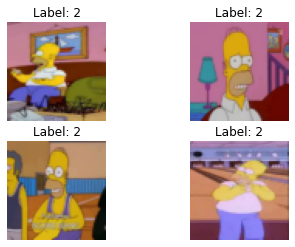

In [5]:
# Show some images from class #2
draw_images(x_train, y_train, 2)
print(x_train.shape)

First, you should normalize the data. Apply a normalisation method of your choice that brings the data around 0, to the scale of 0-1.

Note: you may want to convert the datatype of `x_train` and `x_test` to float32 instead of the original uint8. Fractional values are not representable with a `uint8` datatype. [2p]

In [6]:
# ADD YOUR CODE HERE
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/255
x_test = x_test/255
x_valid = x_valid/255
# IT SHOULD MODIFY x_train, and x_test the same way

## Training the network

Implement and train the following modified LeNet architecture. It has the following layers:

- A convolutional layer with 5x5 kernel and 8 filters
- An AveragePooling layer
- A convolutional layer with 3x3 kernel and 16 filters
- An AveragePooling layer
- A fully connected layer of 100 units
- A fully connected layer of 60 units
- A fully connected layer with softmax activation, having the same number of units as classes

All layers have ReLU activations. 

How many parameters does this network have? [2p]  
**Write your answer here**

Calculating Parameters in a Convolution Layer happens in the following way:
The width of the kernel is multiplied with the height of the kernel, then we multiply this with the number of filters in the previous layer. After this, we add 1 extra for bias parameters. The last step is obviously mulitplying the result with the number if units.

Calculating Parameters in a Dense Layer happens in the following way:
We add 1 to the input size and multiply the result with the output size. The plus one is again for calculating the bias.

Convolutional Layer: ((5 * 5 * 3) + 1) * 8 = 608 parameters
Average Poolig Layer: A pooling layer has 0 parameters. (64,64,8) -> (32,32,8)
Convolutional Layer: ((3 * 3 * 8) + 1) * 16 = 1168 parameters
Average Poolig Layer: A pooling layer has 0 parameters. (32,32,16) -> (16,16,16)
Flatten Layer: A flatten layer has 0 parameters since it only flattens the tensor and makes it 1 dimensional: 16 * 16 * 16 = 4096
1st Dense Layer: (4096 + 1) * 100 = 409700 parameters
2nd Dense Layer: (100 + 1) * 60 = 6060 parameters
3rd Dense Layer: (60 + 1) * 10 = 610 parameters
Number of Parameters: 418,146


Now train the network for 50 epochs. [6p]

In [7]:
# ADD YOUR CODE HERE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import plot_model
print(x_train.shape)
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(5,5), input_shape=x_train.shape[1:], activation='relu', padding="same"))
model.add(MaxPool2D(pool_size=(2,2))) 
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding="same"))
model.add(MaxPool2D(pool_size=(2,2))) 

model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(10, activation='softmax')) # 10 classes

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

(8283, 64, 64, 3)


In [8]:
model.summary()
print(x_train.shape[1:])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         608       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               409700    
_________________________________________________________________
dense_1 (Dense)              (None, 60)                6

In [9]:
#model.summary()
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid))

Epoch 1/50
259/259 [==============================] - 34s 7ms/step - loss: 2.0552 - accuracy: 0.2595 - val_loss: 1.4682 - val_accuracy: 0.5067
Epoch 2/50
259/259 [==============================] - 1s 5ms/step - loss: 1.2976 - accuracy: 0.5728 - val_loss: 1.2842 - val_accuracy: 0.5918
Epoch 3/50
259/259 [==============================] - 1s 5ms/step - loss: 1.0238 - accuracy: 0.6686 - val_loss: 1.0956 - val_accuracy: 0.6364
Epoch 4/50
259/259 [==============================] - 1s 5ms/step - loss: 0.8136 - accuracy: 0.7355 - val_loss: 1.0630 - val_accuracy: 0.6628
Epoch 5/50
259/259 [==============================] - 1s 5ms/step - loss: 0.6423 - accuracy: 0.7918 - val_loss: 0.9526 - val_accuracy: 0.6990
Epoch 6/50
259/259 [==============================] - 1s 5ms/step - loss: 0.4873 - accuracy: 0.8465 - val_loss: 1.0185 - val_accuracy: 0.6885
Epoch 7/50
259/259 [==============================] - 1s 5ms/step - loss: 0.3450 - accuracy: 0.8892 - val_loss: 1.0458 - val_accuracy: 0.7113
Epoch

Now that the model has finished training, plot the accuracy and loss over time, both for the training and the validation data [1p]:

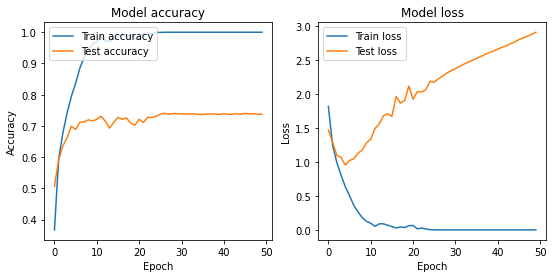

In [10]:
# ADD YOUR CODE HERE
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper left')
plt.show()

#Overfitting
# Validaeion gets stuck on 70%
# Rotate, Mirror

How did the loss and accuracy curves change over time? What does it mean regarding the training process (i.e. overfit, underfit, etc.)? Is that a problem and how would you solve it? [3p]

**Write your answers below**

As the training progressed, the train accuracy was getting better and better, but around 20th epoch the model reached the 100% accuracy, which in this case an obvious sign of overfitting. Here the model learns the exact properties of the training set so well, that now it will know everything for the training set.
This also implies, that the model won't score as well as it could, on the test set, because it contains different values then the training set.
We can see this phenomenon on the accurarcy plot, as it stops right around 70% and it can not be better. This issue can be solved with generating more data (augmentation). In the case of images, we can easily rotate, zoom, shift the images, to generate completely different images. In our case the TV caracters can be recognised even upside down, so it will not affect the logic of our model.
The loss of the training set starts to decrease as it should, and after the 20th epich, it remains pretty close to 0.
In the case of the test set, because of our model being overfit, the loss will start to go up after the point where our model can not predict more labels corectly.


Finally, calculate the performance of your model on the test set [1p]:

In [11]:
# ADD YOUR CODE HERE
loss, acc = model.evaluate(x_test, y_test, verbose=0)

print('Test loss: {}'.format(loss))
print('Test accuracy: {:.2%}'.format(acc))

Test loss: 3.141777753829956
Test accuracy: 73.98%


## Improving the method

Add augmentations to the model, and retrain the network! Plot the training curves as well. [4p]

In [12]:
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

generator = datagen.flow(x_train,y_train)

history = model.fit_generator(
      generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=(x_valid, y_valid),
      validation_steps=50)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 [==============================] - 4s 40ms/step - loss: 2.4735 - accuracy: 0.2359 - val_loss: 1.7273 - val_accuracy: 0.4357
Epoch 2/50
100/100 [==============================] - 4s 38ms/step - loss: 1.7800 - accuracy: 0.4025 - val_loss: 1.3256 - val_accuracy: 0.5762
Epoch 3/50
100/100 [==============================] - 4s 38ms/step - loss: 1.5679 - accuracy: 0.4769 - val_loss: 1.2437 - val_accuracy: 0.6001
Epoch 4/50
100/100 [==============================] - 4s 38ms/step - loss: 1.4986 - accuracy: 0.4955 - val_loss: 1.0938 - val_accuracy: 0.6451
Epoch 5/50
100/100 [==============================] - 4s 38ms/step - loss: 1.4332 - accuracy: 0.5269 - val_loss: 1.0908 - val_accuracy: 0.6346
Epoch 6/50
100/100 [==============================] - 4s 38ms/step - loss: 1.3615 - accuracy: 0.5344 - val_loss: 1.0669 - val_accuracy: 0.6527
Epoch 7/50
100/100 [==============================] - 4s 38ms/step - loss: 1.3227 - accuracy: 0.5566 - val_loss: 1.0417 - val_accuracy: 0.6585
Epoch 8/50

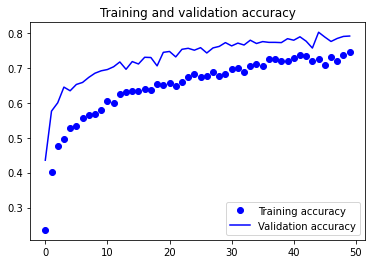

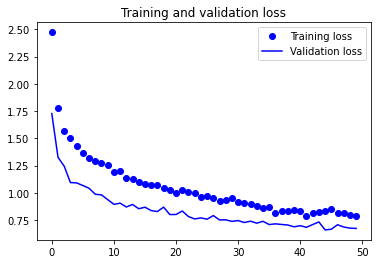

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)

print('Test loss: {}'.format(loss))
print('Test accuracy: {:.2%}'.format(acc))

Test loss: 0.677191436290741
Test accuracy: 78.82%


## Conclusions

You have trianed two models (one with augmentations and one without any). Compare their results. Write a couple of sentences which one would you choose and why. [3p]

Conclusions:

Overfitting is caused by having too few samples to learn from. We solved this with data augmentation and we can see that the test accuracy is also higher then in the previous model, before augmentation. In this specific run we could reach almost 79% accuracy on the test set which is better then 74%.
We can see that the training set accuracy does not get stuck as in the first case, now, it gently approached 80%. 
In the case of the loss, we can see that the loss of the test set now follows the loss of the training set closely, just like in the case of the accuracy.

Based on these, i would use the second model!